# ARCHAEA

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
# import packages
import os
import dokdo
import qiime2 as q2
import pandas as pd
import matplotlib.pyplot as plt
from qiime2.plugins import feature_classifier
from qiime2.plugins import feature_table
from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import filter_seqs
from qiime2.plugins.metadata.visualizers import tabulate

In [3]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [3]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

In [5]:
feature_table.visualizers.summarize(
    table = denoisetable,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: df4526bd-3a17-43b7-b037-35404f7075d1>

## TAXONOMIC ANALYSIS

In [6]:
# load classifier data, archaea classifier classifier-A-SSU1ArF_SSU520R
classifier = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/classifier-A-SSU1ArF_SSU520R.qza')
reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/ref-seqs_SSU1ArF_SSU520R.qza')
reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/silva-138-99-tax.qza')

In [7]:
# define model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [8]:
# choose model, run for each model_name
model_name = "hybrid"
model = models[model_name]

In [9]:
# classify the seqences using different classifiers
# run once for each model
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [10]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [11]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save('./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: 0fdf0bcf-bc57-4d28-9547-6fb3846ebbdc>

In [4]:
# choose a classifier
model_name = "sklearn"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [5]:
# load classification results of a chosen classifier as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: 72184c98-4907-43a1-a543-3a98463a8465>

In [6]:
# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: ca7866c2-2455-42c5-a6d4-e839930caaec>

### FILTER BY TAXONOMY

In [7]:
# filter denoisetable, keep only d_Archaea
denoisetable_ar = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'd__Archaea'
)
denoisetable_ar.filtered_table.save('./results/denoisetable_ar.qza')

'./results/denoisetable_ar.qza'

In [8]:
# filter rep_seqs, keep only d_Archaea

rep_seqs_ar = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'd__Archaea'
)
rep_seqs_ar.filtered_sequences.save('./results/rep_seqs_ar.qza')

'./results/rep_seqs_ar.qza'

### TAXA PER SPECIMEN

In [9]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_ar.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [10]:
# define functions
# define extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

# define backtrace_unassigned 
def backtrace_unassigned(row, unassigned_like_words, invalid_words):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        valid_name = [val for val in row[columns].values if val not in invalid_words][-1]
        row[columns] = [val if val not in invalid_words else f"Unclass. {valid_name}" for val in row[columns].values]
        
        valid_name = [val for val in row[columns].values if val not in unassigned_like_words][-1]
        row[columns] = [val if val not in unassigned_like_words else f"Unclass. {valid_name}_{val}" for val in row[columns].values]
    except:
        pass
    return row

# define reassemble taxon column
def reassemble_taxon(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    prefixes = ['d__', 'p__', 'c__', 'o__', 'f__', 'g__']
    return ";".join(["".join(pair) for pair in zip(prefixes, row[columns].values)])


# remove duplicates
def remove_duplicates(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        values = [val for val in row[columns].values if "Unclass." not in val]
        unique_values, counts = np.unique(values, return_counts=True)
        duplicate_id = np.where(counts > 1)[0][0] if any(counts > 1) else None
        
        if duplicate_id is not None:
            count = counts[duplicate_id]
            duplicate_str = unique_values[duplicate_id]
            joined_str = '|'.join(row[columns].values[::-1])
            row[columns] = re.sub(duplicate_str, f'Unclass. {duplicate_str}', joined_str, count=count-1).split('|')[::-1]
    except:
        pass
    return row

In [11]:
# run once for each sample (subject)
# choose a sample 
subject = 'P05A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__', null_data='Unassigned'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__', null_data='Unassigned'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__', null_data='Unassigned'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__', null_data='Unassigned'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__', null_data='Unassigned'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__', null_data='Unassigned'))
#custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

invalid_words = ['metagenome', 'uncultured_euryarchaeote', 'uncultured_archaeon',"Unassigned"]
unassigned_like_words = [ 'Marine_Group_II']
custom_df = custom_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

custom_df['Taxon'] = custom_df.apply(reassemble_taxon, axis=1)
custom_df = custom_df.apply(remove_duplicates, axis=1)

columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus']#, 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
taxa_per_species[subject] /= taxa_per_species[subject].sum()
taxa_per_species[subject] = [f'{x*100:.3f}' for x in taxa_per_species[subject]]

print(taxa_per_species.to_latex(escape=False))

#taxa_per_species

\begin{tabular}{llllll}
\toprule
              &              &                 &                 &                 &     P05A \\
Phylum & Class & Order & Family & Genus &          \\
\midrule
Nanoarchaeota & Nanoarchaeia & Woesearchaeales & Woesearchaeales & Woesearchaeales &  100.000 \\
\bottomrule
\end{tabular}



### VISUALIZATIONS

In [12]:
# prepare new_taxonomy file with taxonomy corrections, same as above
taxonomy_df = taxonomy.view(pd.DataFrame)

taxonomy_df['Domain'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='d__', null_data='Unassigned')
taxonomy_df['Phylum'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
taxonomy_df['Class'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
taxonomy_df['Order'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
taxonomy_df['Family'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
taxonomy_df['Genus'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ['metagenome', 'uncultured_euryarchaeote', 'uncultured_archaeon', "Unassigned"]
unassigned_like_words = [ 'Marine_Group_II']
taxonomy_df = taxonomy_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

taxonomy_df['Taxon'] = taxonomy_df.apply(reassemble_taxon, axis=1)
taxonomy_df = taxonomy_df.apply(remove_duplicates, axis=1)

new_taxonomy = q2.Artifact.import_data("FeatureData[Taxonomy]", taxonomy_df)

In [13]:
new_taxonomy.view(view_type = pd.DataFrame)

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
2ac5ece8b45328cf319e3d2dde988883,d__Eukaryota;p__Heterolobosea;c__Tetramitia;o_...,0.9999999999987026,Eukaryota,Heterolobosea,Tetramitia,Tetramitia,Tetramitia,Naegleria
5d475f1c4ca43de7f1db4beccd9e922a,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9998461178409673,Archaea,Thermoplasmatota,Thermoplasmata,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II
5fd89c0226473f4cf26fa26e15aaa763,d__Bacteria;p__Unclass. Bacteria;c__Unclass. B...,0.7746433568454731,Bacteria,Unclass. Bacteria,Unclass. Bacteria,Unclass. Bacteria,Unclass. Bacteria,Unclass. Bacteria
7552b285840ebdd0b1d71778c2e10446,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.44345505448816747,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
0efba06ead52484fb83cbe9fdaa53a8d,d__Bacteria;p__Unclass. Bacteria;c__Unclass. B...,0.7221020273250013,Bacteria,Unclass. Bacteria,Unclass. Bacteria,Unclass. Bacteria,Unclass. Bacteria,Unclass. Bacteria
...,...,...,...,...,...,...,...,...
6393e4ed57f383ae6eef479dc80334eb,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.4567079883015408,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
52828153d53730fbc273948806794f23,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.42636235809439804,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
92bc27c5d48a567b16e106f036b22301,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.388766289358877,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned


In [14]:
new_taxonomy_df = new_taxonomy.view(view_type = pd.DataFrame)
new_taxonomy_df = new_taxonomy_df.query("Domain == 'Archaea'")
new_taxonomy_df

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
5d475f1c4ca43de7f1db4beccd9e922a,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9998461178409673,Archaea,Thermoplasmatota,Thermoplasmata,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II
8c9cce9b5a4857bc9cc3c39204799426,d__Archaea;p__Unclass. Archaea;c__Unclass. Arc...,0.9999993225881821,Archaea,Unclass. Archaea,Unclass. Archaea,Unclass. Archaea,Unclass. Archaea,Unclass. Archaea
25422b301a06f7bd685f1731770016ec,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,0.9646580301088062,Archaea,Nanoarchaeota,Nanoarchaeia,Woesearchaeales,Woesearchaeales,Woesearchaeales
0eea051b7d547c0377a385e1a95c3893,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,0.995193022085948,Archaea,Nanoarchaeota,Nanoarchaeia,Woesearchaeales,Woesearchaeales,Woesearchaeales
b5d89f5cf0ddc1eb17fbafe964a4f672,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,0.9984367095006734,Archaea,Nanoarchaeota,Nanoarchaeia,Woesearchaeales,Woesearchaeales,Woesearchaeales
f9abde7ffb072b2be31cb2dbb39f9426,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9991636752445879,Archaea,Thermoplasmatota,Thermoplasmata,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II
93ec640b7aa0f0dce5aee7ffc053a2b6,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9996687865980456,Archaea,Thermoplasmatota,Thermoplasmata,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II
d4d27c643323d6dd14eb7472acc17bd5,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9996732375918947,Archaea,Thermoplasmatota,Thermoplasmata,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II
cac7f5dd165d37587931bb350f560db9,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9998641246559794,Archaea,Thermoplasmatota,Thermoplasmata,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II,Unclass. Thermoplasmata_Marine_Group_II


In [15]:
for col in columns:
    cases = new_taxonomy_df.query(f"not {col}.str.contains('Unclass.')")[col]
    print(f'{col}: {cases.nunique()}')
    print(cases.unique().tolist())
    print('')

Phylum: 2
['Thermoplasmatota', 'Nanoarchaeota']

Class: 2
['Thermoplasmata', 'Nanoarchaeia']

Order: 1
['Woesearchaeales']

Family: 1
['Woesearchaeales']

Genus: 1
['Woesearchaeales']



In [16]:
# visualise classifications in qiime2
taxa_bar_plot = barplot(
    table = denoisetable_ar.filtered_table,
    taxonomy = new_taxonomy,
    metadata = sample_metadata
).visualization

In [17]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots.qzv')

'./results/taxa_bar_plots.qzv'

In [18]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

1. ylabel: relativna abundanca arhejskih taksonov (%)
2. xlabel: osebki

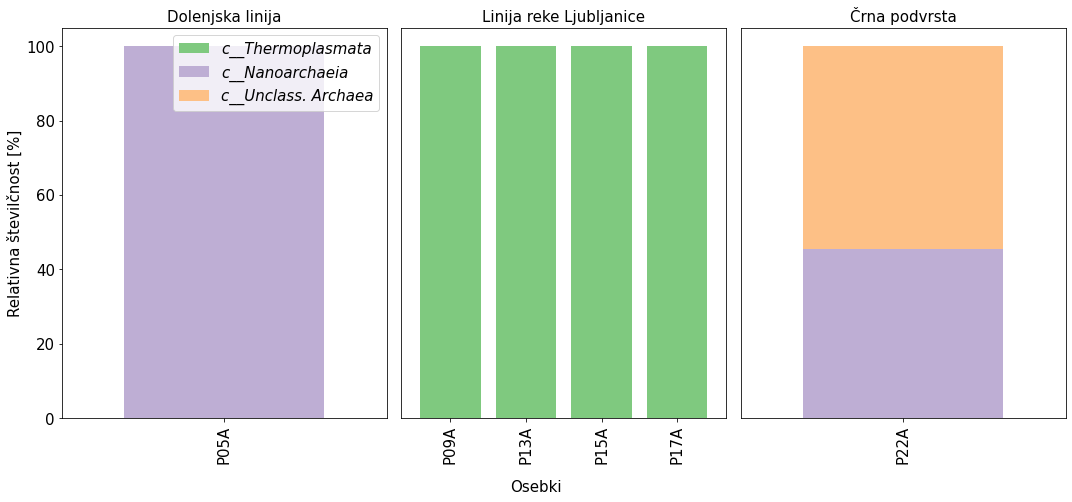

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

groups = ['Dolenjska linija', 'Linija reke Ljubljanice', 'Črna podvrsta']
kwargs = dict(level=3, count=8, sort_by_mean2=False)

for i, group in enumerate(groups):
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=axes[i],
        include_samples={'population': [group]},
        cmap_name='Accent',
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(group)

# custom properties
fig.supxlabel('Osebki', fontsize = 15)
axes[0].set_ylabel('Relativna številčnost [%]')


for idx, ax in enumerate(axes):
    ax.tick_params(axis='x', labelrotation = 90, labelsize=15)  # reset rotation
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(15)
    
    if idx == 0:
        ax.legend(prop={'size': 15, 'style': 'italic'})
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations_archaea.png')